# Практическая работа 3

# Визуализация многомерных данных. Создание пиктограмм при помощи Matplotlib.

## Вариант 5

In [44]:
# Install a pip package in the current Jupyter kernel
import sys
import zipfile
import os

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from IPython.display import Image
from matplotlib.patches import Ellipse, PathPatch, Arc, Polygon, Wedge

plt.rcParams['figure.dpi'] = 300

### Загрузка данных

In [45]:
source_data = pd.read_csv("bldg-MC2.csv")
source_data['Date/Time'] = pd.to_datetime(source_data['Date/Time'])
source_data['Date'] = source_data['Date/Time'].dt.date
source_data = [group[1] for group in source_data.groupby(['Date'])]

source_data = [df.filter(regex='^ F_2_Z_4') for df in source_data]
source_data = [df.rename(columns=lambda x: x.strip()) for df in source_data]

for df in source_data:
    df.reset_index(drop= True, inplace= True)

In [46]:
tracked_columns = []

# записываем нужные нам колонки
for elem in source_data[0].columns:
        tracked_columns.append(elem)
        
print(tracked_columns)

['F_2_Z_4: Lights Power', 'F_2_Z_4: Equipment Power', 'F_2_Z_4: Thermostat Temp', 'F_2_Z_4: Thermostat Heating Setpoint', 'F_2_Z_4: Thermostat Cooling Setpoint', 'F_2_Z_4 VAV REHEAT Damper Position', 'F_2_Z_4 REHEAT COIL Power', 'F_2_Z_4 RETURN OUTLET CO2 Concentration', 'F_2_Z_4 SUPPLY INLET Temperature', 'F_2_Z_4 SUPPLY INLET Mass Flow Rate']


### О данных

| **Field** |**Description** | **type** |
|---|---|---|
| **F_2_Z_4: Lights Power**                   | Мощность света                                                    | float64 |
| **F_2_Z_4: Equipment Power**                | Мощность оборудования                                             | float64 |
| **F_2_Z_4: Thermostat Temp**                | Температура термостата                                            | float64 |
| **F_2_Z_4: Thermostat Heating Setpoint**    | Заданное значение нагрева термостата                              | float64 |
| **F_2_Z_4: Thermostat Cooling Setpoint**    | Заданное значение охлаждения термостата                           | float64 |
| **F_2_Z_4 VAV REHEAT Damper Position**      | Положение заслонки потвторного нагрева переменного объема воздуха | float64 |
| **F_2_Z_4 REHEAT COIL Power**               | Мощность катушки повторного нагрева                               | float64 |
| **F_2_Z_4 RETURN OUTLET CO2 Concentration** | Концентрация СО2 на обратном выходе                               | float64 |
| **F_2_Z_4 SUPPLY INLET Temperature**        | Температура подачи на входе                                       | float64 |
| **F_2_Z_4 SUPPLY INLET Mass Flow Rate**     | Массовый расход подачи на входе                                   | float64 |

In [47]:
# извлекаем данные в новый DataFrame
HVAC_data = pd.DataFrame()

HVAC_data = [d[tracked_columns] for d in source_data]

print(HVAC_data[0].head())

   F_2_Z_4: Lights Power  F_2_Z_4: Equipment Power  F_2_Z_4: Thermostat Temp  \
0              1199.5641                  839.6948                   25.5576   
1                 0.0000                  167.9390                   24.8122   
2                 0.0000                  167.9390                   24.3406   
3                 0.0000                  167.9390                   24.0470   
4                 0.0000                  167.9390                   23.8554   

   F_2_Z_4: Thermostat Heating Setpoint  F_2_Z_4: Thermostat Cooling Setpoint  \
0                                  15.6                                  26.7   
1                                  15.6                                  26.7   
2                                  15.6                                  26.7   
3                                  15.6                                  26.7   
4                                  15.6                                  26.7   

   F_2_Z_4 VAV REHEAT Damper Pos

In [48]:
scaled_data = HVAC_data
for i, df in enumerate(HVAC_data):
    scaled_temp = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(df), 
    columns=df.columns    )
    scaled_data[i]=scaled_temp
scaled_data[0].head()
HVAC_data = scaled_data

## Вычисление корреляции между признаками в данных

In [49]:
def get_empty_columns_names(df):
    empty = [col for col in df.columns if (df[col].isnull().all() or df[col].isna().all())]
    return empty


def heatmap(df, ax, title):
    corr = df.corr()

    # Omit pairs with weak correlation, try to experiments with this setting
    df_corr = corr[((corr >= .6) | (corr <= -.6))]

    #print("Empty columns:", get_empty_columns_names(df_corr))

    mask = np.triu(np.ones_like(corr))
    sns.heatmap(
        df_corr, 
        cbar=False, 
        mask=mask,
        ax=ax, 
        annot=True, 
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
    )

    ax.title.set_text(title)
    ax.tick_params(
        top=False,
        bottom=False,
        left=False,
        right=False,
    )

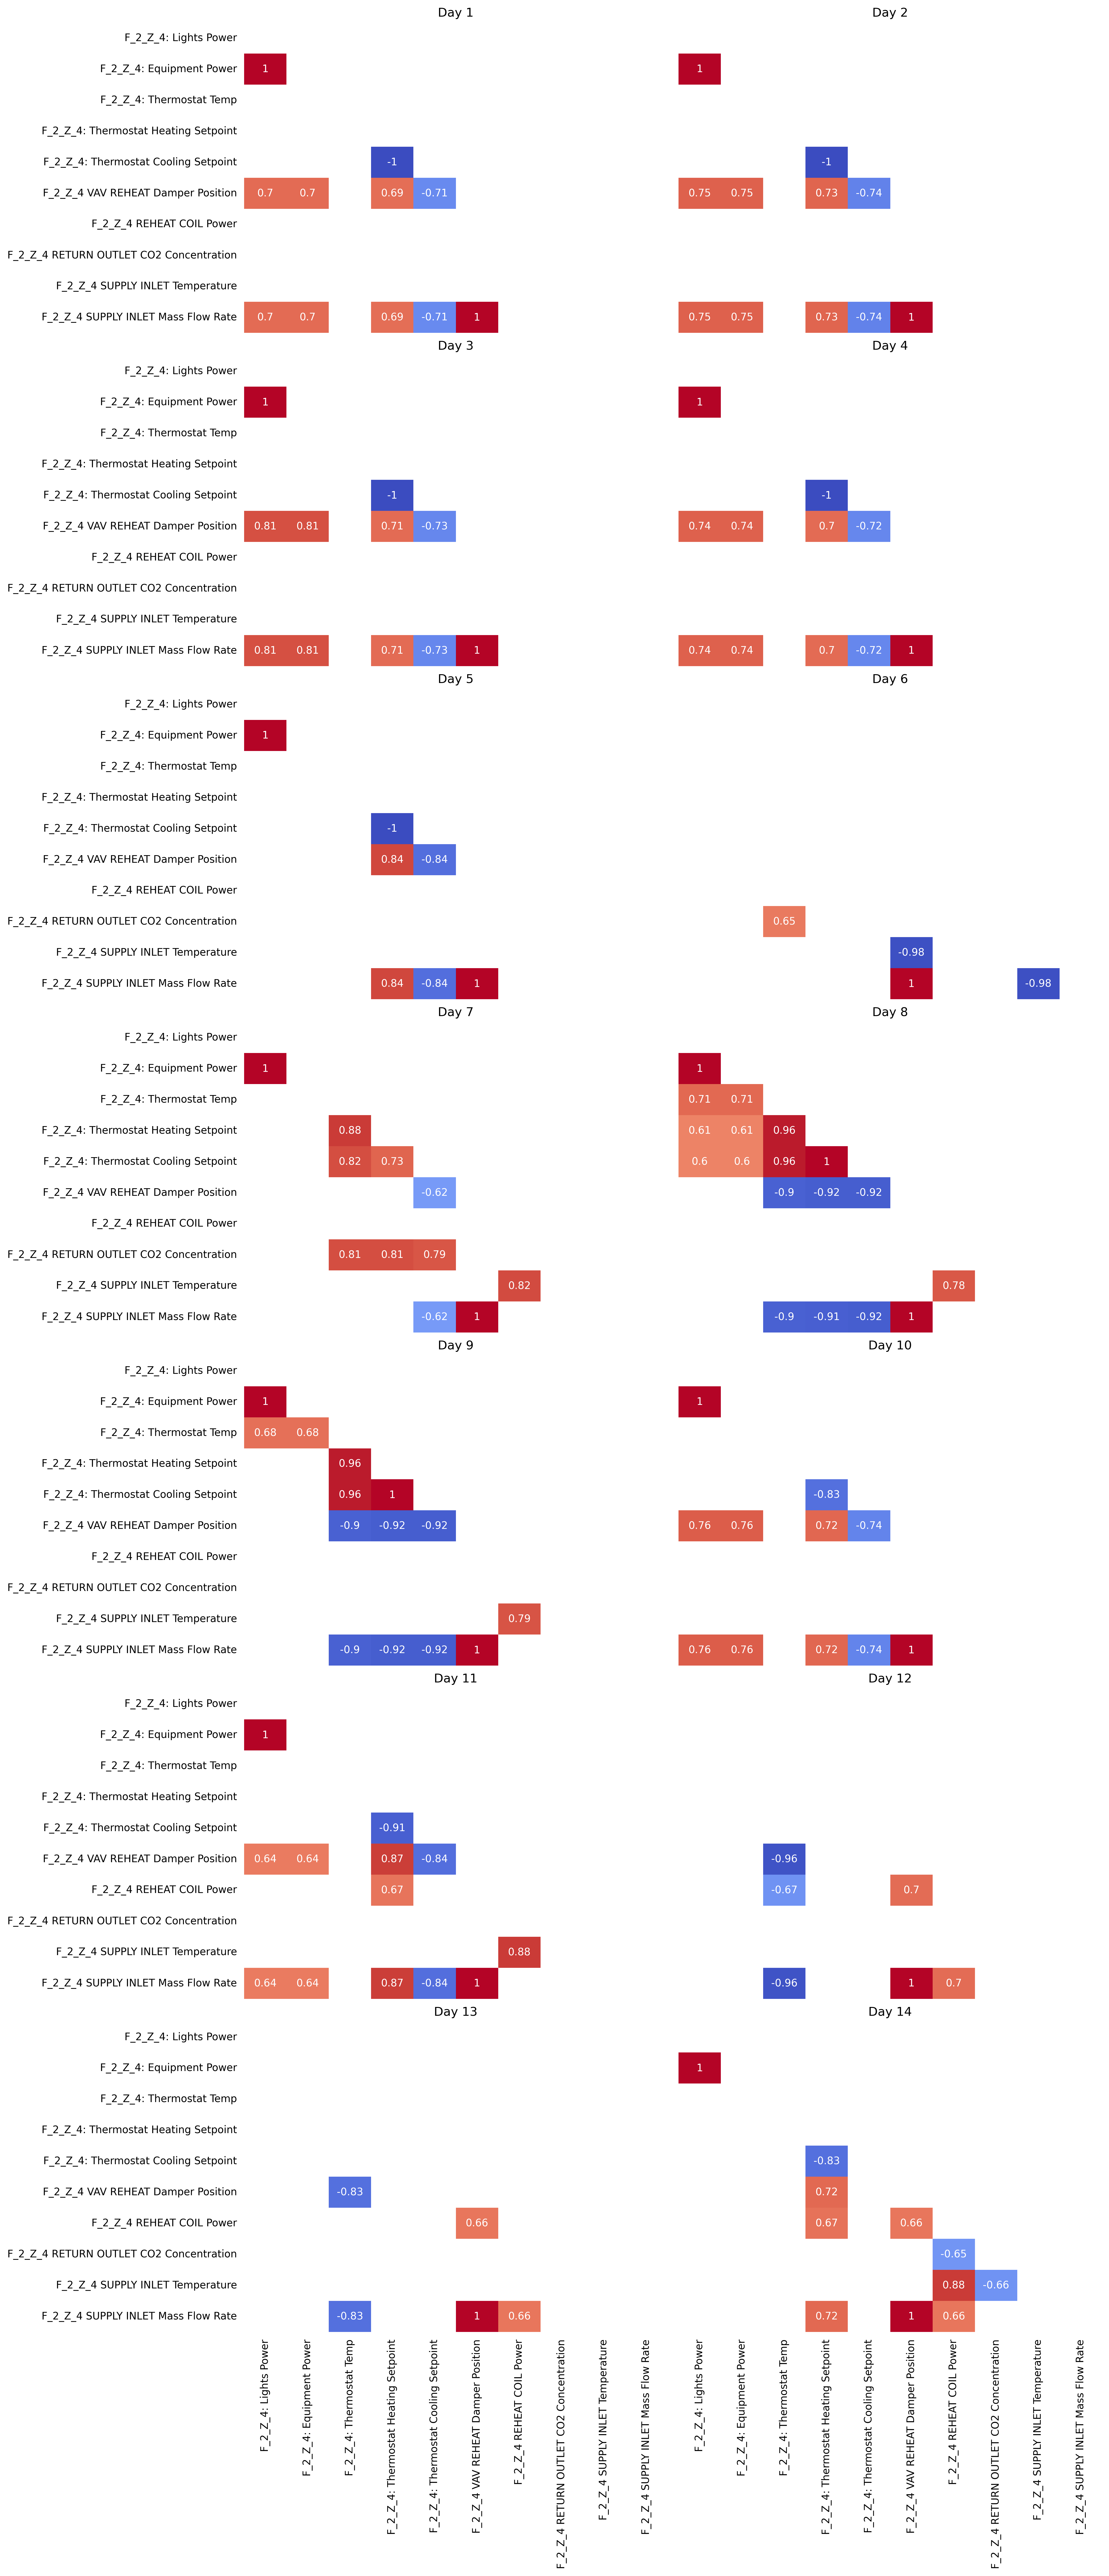

In [50]:
fig, ax = plt.subplots(
    nrows=7, 
    ncols=2, 
    sharey=True, 
    sharex=True, 
    figsize=(15, 35), 
    constrained_layout=True
)

axes = ax.flatten()

for i, df in enumerate(HVAC_data):
    heatmap(df, axes[i], f"Day {i + 1}")

plt.savefig("matrix.png", bbox_inches="tight")
plt.close()

img = Image("matrix.png")
img

## Реализация лиц Чернова 

### Схема кодирования

| **Field** | **Face feature** |
|---|---|
| **F_2_Z_4: Lights Power**                   | Мощность света - высота глаза слева |
| **F_2_Z_4: Equipment Power**                | Мощность оборудования - высота глаза справа |
| **F_2_Z_4: Thermostat Temp**                | Температура термостата - цвет волос |
| **F_2_Z_4: Thermostat Heating Setpoint**    | Заданное значение нагрева термостата - длина волос слева |
| **F_2_Z_4: Thermostat Cooling Setpoint**    | Заданное значение охлаждения термостата - длина волос справа |
| **F_2_Z_4 VAV REHEAT Damper Position**      | Положение заслонки повторного нагрева переменного объема воздуха - бровь слева |
| **F_2_Z_4 REHEAT COIL Power**               | Мощность катушки повторного нагрева - бровь справа |
| **F_2_Z_4 RETURN OUTLET CO2 Concentration** | Концентрация СО2 на обратном выходе - ширина рта |
| **F_2_Z_4 SUPPLY INLET Temperature**        | Температура подачи на входе - ширина носа |
| **F_2_Z_4 SUPPLY INLET Mass Flow Rate**     | Массовый расход подачи на входе - цвет лица |

### Расчет средних показателей экспериментов (для их дальнейшей визуализации)


In [51]:
mean_data = []

for i, df in enumerate(HVAC_data):
    mean_data.append([*df.mean().tolist()])

mean_df = pd.DataFrame(mean_data, columns=tracked_columns)
mean_df.to_csv('mean_df1.csv', index=False)

reindexed_columns = [ 
    'F_2_Z_4: Thermostat Temp', #цвет волос
    'F_2_Z_4 SUPPLY INLET Mass Flow Rate', # цвет лица
    'F_2_Z_4: Thermostat Heating Setpoint',#+ длина волос слева  
    'F_2_Z_4: Thermostat Cooling Setpoint', #+ длина волос справа
    'F_2_Z_4 VAV REHEAT Damper Position', #брови слева
    'F_2_Z_4 REHEAT COIL Power', # брови справа
    'F_2_Z_4: Lights Power', # глаза слева
    'F_2_Z_4: Equipment Power', #глаза справа
    'F_2_Z_4 SUPPLY INLET Temperature', # ширина носа
    'F_2_Z_4 RETURN OUTLET CO2 Concentration', # ширина рта
]

mean_df = mean_df.reindex(columns=reindexed_columns)
mean_df.to_csv('mean_df2.csv', index=False)

### Определение класса лиц Чернова 

In [52]:
class ChernoffFaces:

    DATA = {
        "HAIR_COLOR": None,
        "SKIN_COLOR": None,    
        "HAIR_LEFT": None, 
        "HAIR_RIGHT": None, 
        "EYEBROW_CURVATURE_LEFT": None,
        "EYEBROW_CURVATURE_RIGHT": None,
        "EYE_HEIGHT_LEFT": None,
        "EYE_HEIGHT_RIGHT": None,
        "PUPIL_SIZE": 0.2,        
        "NOSE_WIDTH": None,
        "MOUTH_HEIGHT": 0.2,
        "MOUTH_WIDTH": None,
    }

    DYNAMIC_PARAMETERS = [
        "HAIR_COLOR",
        "SKIN_COLOR",  
        "HAIR_LEFT",
        "HAIR_RIGHT",
        "EYEBROW_CURVATURE_LEFT",
        "EYEBROW_CURVATURE_RIGHT",
        "EYE_HEIGHT_LEFT",
        "EYE_HEIGHT_RIGHT",
        "NOSE_WIDTH",
        "MOUTH_WIDTH",
    ]

    def __init__(self, df, labels=None, filename='faces'):

        if not labels:
            self.labels = df.iloc[:,0].values
            df = df[df.columns.drop(df.columns[0])]

        self.data = df

        for index, key in enumerate(self.DYNAMIC_PARAMETERS):
            self.DATA[key] = self.data[self.data.columns[index % len(self.data.columns)]].values.tolist()

        
        self.filename = filename

    def render_face(self, ax, title='', index=None):

        height, width = ax.bbox.height, ax.bbox.width

        self.draw_hair(ax, index, width, height)
        self.draw_face(ax, index, width, height)
        self.draw_l_brow(ax, index)
        self.draw_r_brow(ax, index)
        self.draw_l_eye(ax, index)
        self.draw_r_eye(ax, index)
        self.draw_nose(ax, index)   
        self.draw_mouth(ax, index)

        ax.title.set_text(title)
        ax.axis('off')
        ax.autoscale()

    def draw_hair(self, ax, index, width, height):

        hair_width = width
        hair_height = height

        colour = plt.cm.coolwarm(self.DATA["HAIR_COLOR"][index])  #настройка цветов

        trapeze = Polygon(
            xy=[
                [0, hair_height * 0.5 * (1 - self.DATA["HAIR_LEFT"][index])],
                [0, hair_height * 0.5],
                [hair_width, hair_height * 0.5],
                [hair_width, hair_height * 0.5 * (1 - self.DATA["HAIR_RIGHT"][index])],
            ], 
            fc=colour
        )
        ax.add_patch(trapeze)

        top = Wedge(
            center=[hair_width / 2, hair_height * 0.5 - 1], 
            r=hair_width / 2,
            theta1=0, 
            theta2=180,
            edgecolor='none', 
            fc=colour,
        )
        ax.add_patch(top)

    def draw_face(self, ax, index, width, height):

        face_width = width * 2/3
        face_height = height * 1/2
        self.UNIT_WIDTH = face_width / 7
        self.UNIT_HEIGHT = face_height / 7
        self.FACE_CENTER = [width / 2, height / 2]

        colour = plt.cm.RdBu(self.DATA["SKIN_COLOR"][index]) #настройка цветов

        ellipse = Ellipse(
        xy=self.FACE_CENTER, 
        width=face_width, 
        height=face_height, 
        edgecolor='black', 
        fc=colour, 
        lw=2
        )
        ax.add_patch(ellipse)

    def draw_l_brow(self, ax, index):

        brow_width = self.UNIT_WIDTH * 1.5
        brow_height =  self.UNIT_HEIGHT * self.DATA["EYEBROW_CURVATURE_LEFT"][index]
        if brow_height == 0:
            brow_height = 0.001

        brow_l_center = [sum(i) for i in zip(*[ 
            self.FACE_CENTER, 
            [brow_width,  self.UNIT_HEIGHT * 1.1] 
        ])]

        brow_l = Arc(
            xy=brow_l_center, 
            width=brow_width, 
            height=brow_height, 
            theta1=0, 
            theta2=180,
            edgecolor='black', 
            fc='None', 
            lw=2
        )
        ax.add_patch(brow_l)

    def draw_r_brow(self, ax, index):

        brow_width = self.UNIT_WIDTH * 1.5
        brow_height =  self.UNIT_HEIGHT * self.DATA["EYEBROW_CURVATURE_RIGHT"][index]

        if brow_height == 0:
            brow_height = 0.001

        brow_r_center = [sum(i) for i in zip(*[ 
            self.FACE_CENTER, 
            [-brow_width,  self.UNIT_HEIGHT * 1.1] 
        ])]

        brow_r = Arc(
            xy=brow_r_center, 
            width=brow_width, 
            height=brow_height, 
            theta1=0, 
            theta2=180,
            edgecolor='black', 
            fc='None', 
            lw=2
        )
        ax.add_patch(brow_r)

    def draw_l_eye(self, ax, index):

        eye_width = self.UNIT_WIDTH * 1.5
        eye_height =  self.UNIT_HEIGHT * self.DATA["EYE_HEIGHT_LEFT"][index] 

        if eye_height == 0:
            eye_height = 0.001

        eye_l_center = [sum(i) for i in zip(*[ 
            self.FACE_CENTER, 
            [-eye_width,  self.UNIT_HEIGHT / 2] 
        ])]

        ellipse = Ellipse(
            xy=eye_l_center, 
            width=eye_width, 
            height=eye_height, 
            edgecolor='black', 
            fc='white', 
            lw=1
        )
        ax.add_patch(ellipse)

        ellipse = Ellipse(
            xy=eye_l_center, 
            width=eye_width / 2, 
            height=eye_height, 
            edgecolor='black', 
            fc='black', 
            lw=1
        )
        ax.add_patch(ellipse)

    def draw_r_eye(self, ax, index):

        eye_width = self.UNIT_WIDTH * 1.5
        eye_height =  self.UNIT_HEIGHT * self.DATA["EYE_HEIGHT_RIGHT"][index] 

        if eye_height == 0:
            eye_height = 0.001

        eye_r_center = [sum(i) for i in zip(*[ 
            self.FACE_CENTER, 
            [eye_width,  self.UNIT_HEIGHT / 2] 
        ])]

        ellipse = Ellipse(
            xy=eye_r_center, 
            width=eye_width, 
            height=eye_height, 
            edgecolor='black', 
            fc='white', 
            lw=1
        )
        ax.add_patch(ellipse)   

        ellipse = Ellipse(
            xy=eye_r_center, 
            width=eye_width / 2, 
            height=eye_height, 
            edgecolor='black', 
            fc='black', 
            lw=1
        )
        ax.add_patch(ellipse)

    def draw_nose(self, ax, index):

        nose_width = self.UNIT_WIDTH * (1 - self.DATA["NOSE_WIDTH"][index])
        nose_height =  self.UNIT_HEIGHT  

        pivot_left = [sum(i) for i in zip(*[ 
            self.FACE_CENTER, 
            [-nose_width / 2,  -nose_height] 
        ])]

        pivot_right = [sum(i) for i in zip(*[ 
            self.FACE_CENTER, 
            [nose_width / 2,  -nose_height] 
        ])]

        pivot_top = self.FACE_CENTER

        points = np.array([pivot_left, pivot_right, pivot_top])
        nose = plt.Polygon(
            points, 
            closed=True, 
            lw=1,
            fc="black", 
            edgecolor='black',
        )
        ax.add_patch(nose)

    def draw_mouth(self, ax, index):

        mouth_width = self.UNIT_WIDTH * 3 * self.DATA["MOUTH_WIDTH"][index] 
        mouth_height = self.UNIT_HEIGHT * 1.5 * self.DATA["MOUTH_HEIGHT"]

        mouth_center = [sum(i) for i in zip(*[ 
            self.FACE_CENTER, 
            [0,  -self.UNIT_HEIGHT * 2] 
        ])]

        ellipse = Ellipse(
            xy=mouth_center, 
            width=mouth_width, 
            height=mouth_height, 
            edgecolor='black', 
            fc="black",  
            lw=1
        )
        ax.add_patch(ellipse)

    def render(self, n_cols=2, n_rows=1, figsize=(2, 2), empty_cols_ids=()):
        fig, ax = plt.subplots(
            nrows=n_rows, 
            ncols=n_cols, 
            figsize=figsize, 
            sharey=True,
            sharex=True,
            constrained_layout=True,
        )
        fig.patch.set_facecolor('white')
        axes = ax.flatten()
        for i, ax in enumerate(axes):
            if i in empty_cols_ids:
                ax.remove()
            if i == 0:
                self.render_face(ax, title=f"Reference", index=i)
                continue
            self.render_face(ax, title=f"Day {i}", index=i)

        plt.savefig(f"{self.filename}.png", bbox_inches="tight")
        plt.close()

### Построение визуализации для экспериментов


In [53]:
reference = pd.DataFrame([(0.5 for _ in range(10))], columns=reindexed_columns)

mean_df = pd.DataFrame(
   preprocessing.MinMaxScaler().fit_transform(mean_df.values), 
    columns=mean_df.columns
)

mean_df = pd.concat([reference, mean_df])

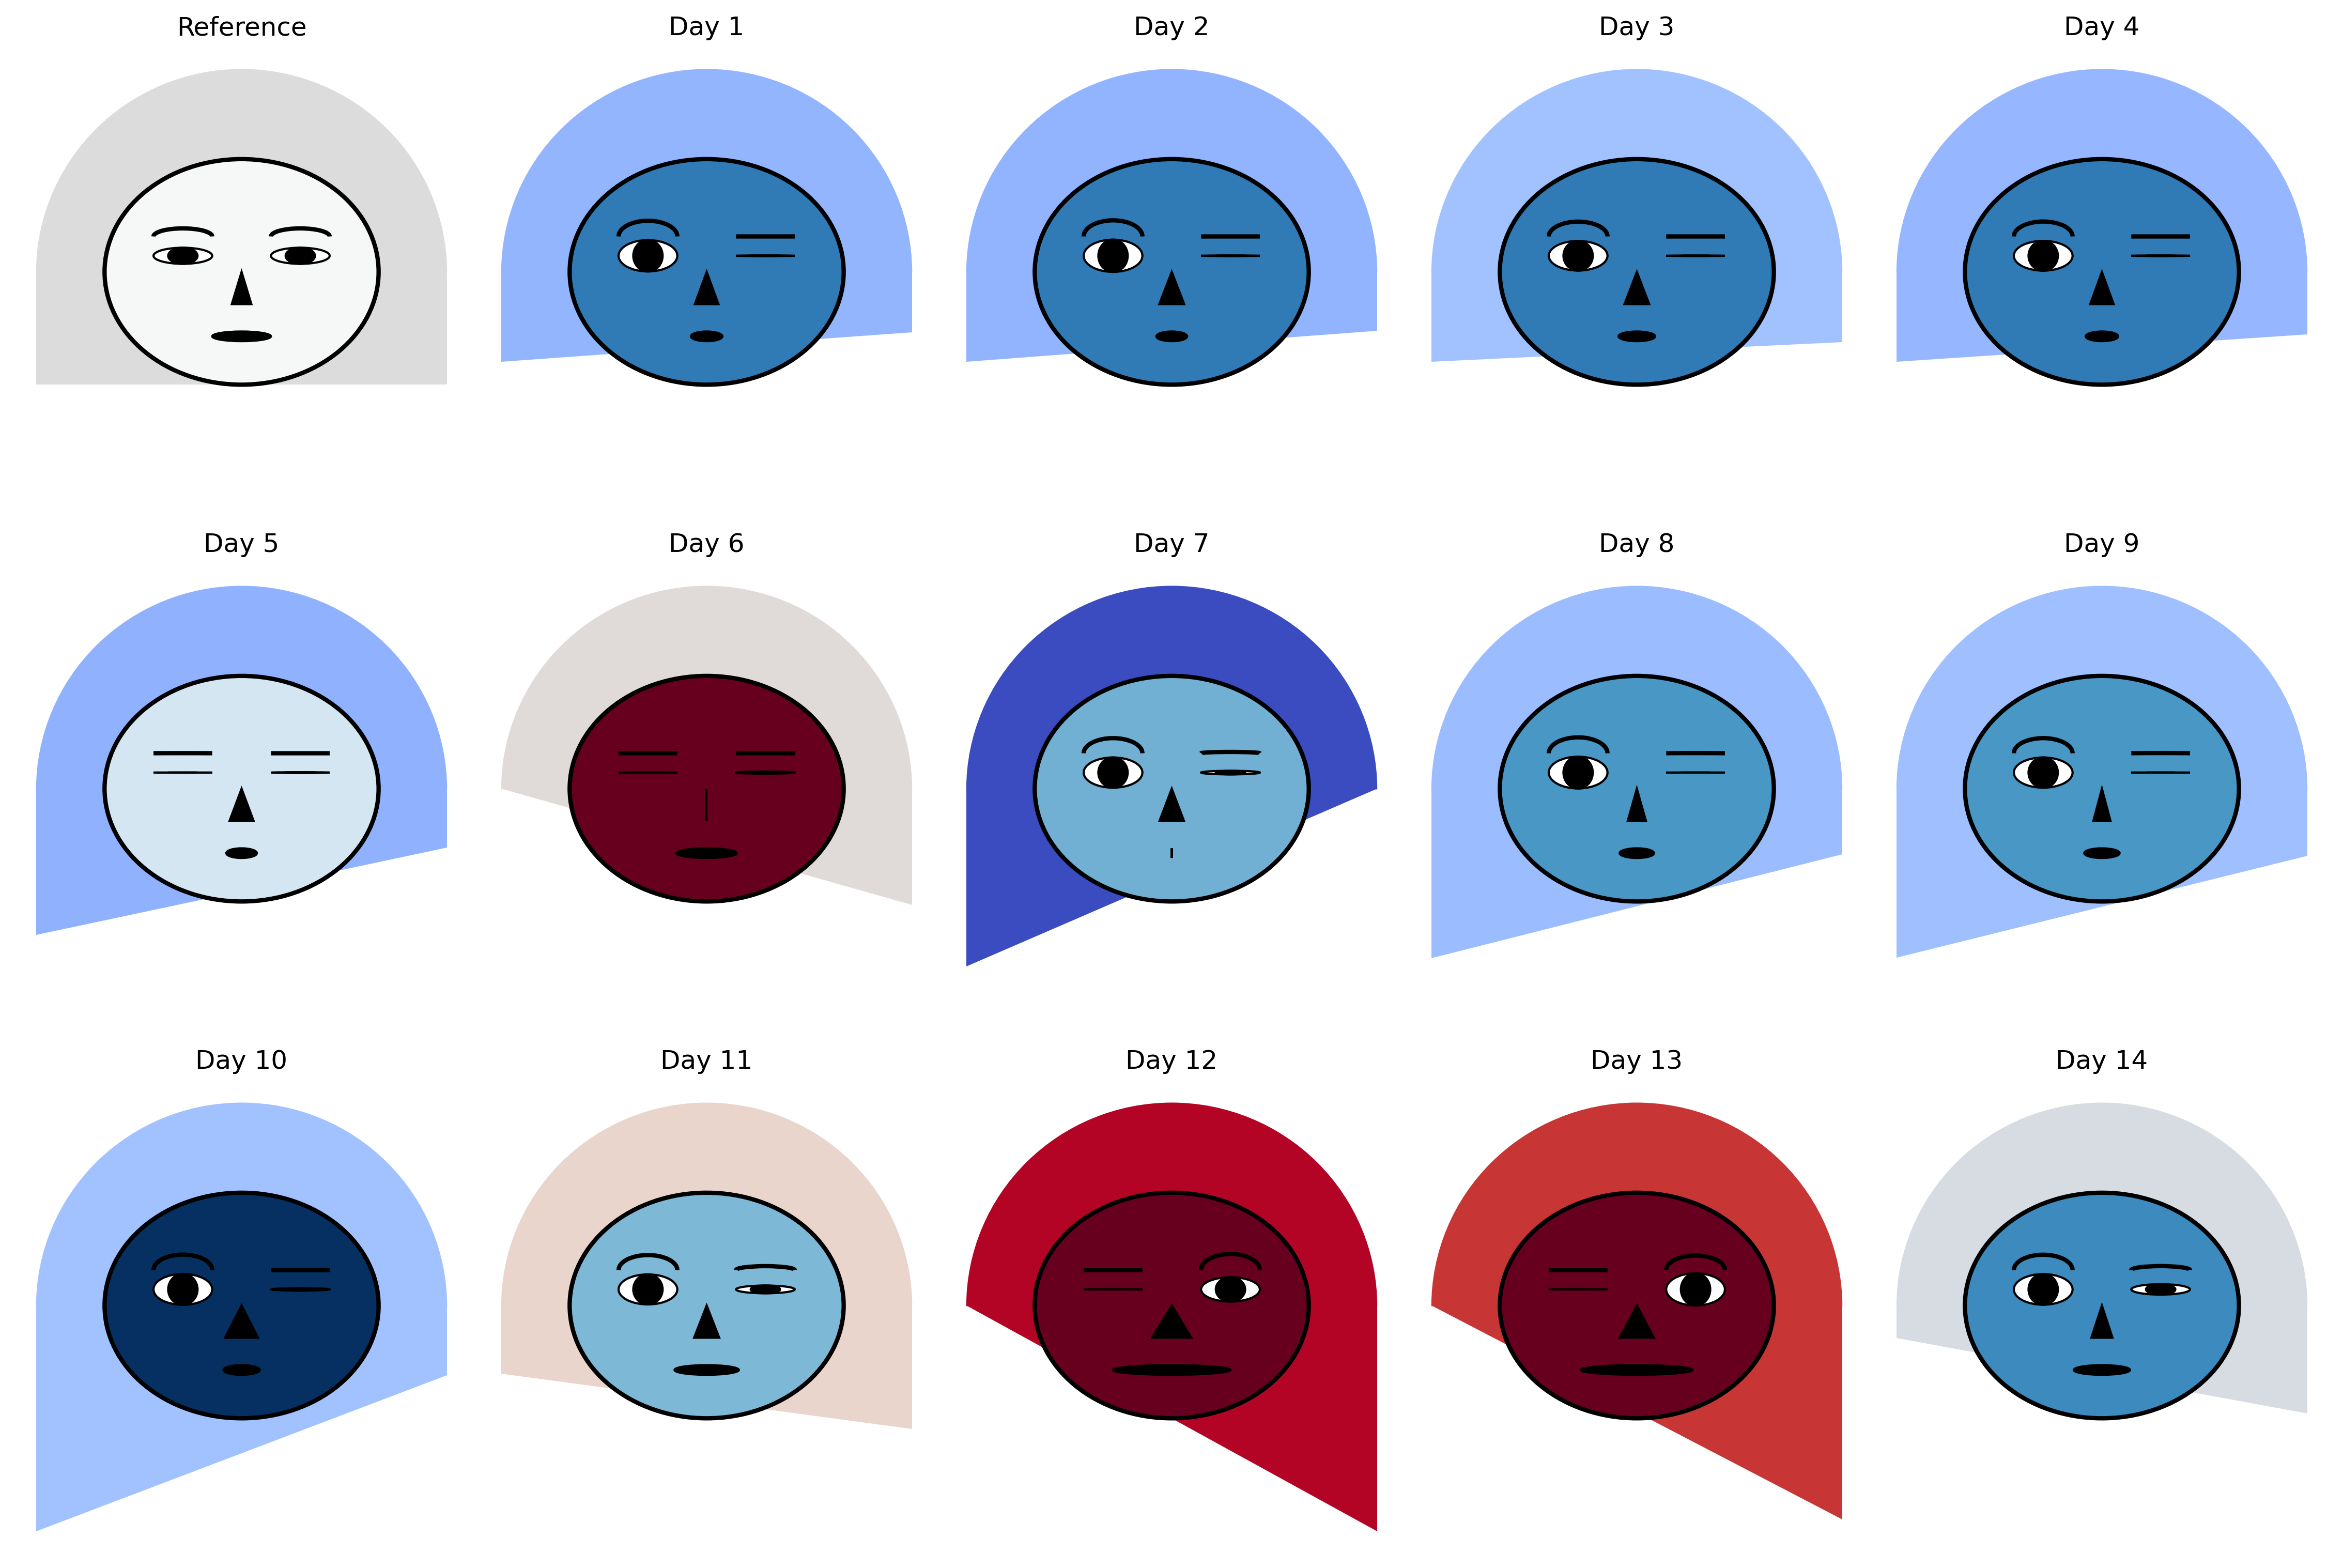

In [54]:
c = ChernoffFaces(mean_df)
c.render(
    n_cols = 5,
    n_rows = 3,
    figsize=(15, 10),
)

img = Image("faces.png")
img